## Recongnizing outliers from multivariate data

In this notbook, I try to identify outliers from a multivariate data set with manufacturing context by using sklearn built-in outlier removal algorithms, and with the help of [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), to plot 2 dimensional chart of high dimensional data. The [algorithms](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html#sphx-glr-auto-examples-miscellaneous-plot-anomaly-comparison-py)
 that are going to be used in the notebook are isolation forest,robust variance, local outliers, one-class SVM.
 
- Basic idea of each model:

    __1. Isolation Forest__: 
    
    Since the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node. This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

    __2.Robust variance__:
    
    Assumes the data is Gaussian and learns an ellipse. It thus degrades when the data is not unimodal. Notice however that this estimator is robust to outliers.
    
    __3.Local Outliers__:
    
    The anomaly score of each sample is called Local Outlier Factor. It measures the local deviation of density of a given sample with respect to its neighbors.
    
     __4. one-class SVM__:
    
    It is known to be sensitive to outliers and thus does not perform very well for outlier detection. This estimator is best suited for novelty detection (detecting ouliers from new samples) when the training set is not contaminated by outliers. 
    
    

## Table of Contents:

[1. Data Clean](#1.-Data-Clean)

[2. Dimension Reduction](#2.-PCA)

[3. Visualization](#3.-Visualization)

[4. Models](#4.-Isolation-Forest)

[5. Conclusion](#Conclusion )






In [336]:
#!pip install pingouin

## 1. Data Clean

Basically not too much data clean can do in this case, just check null value or any trivial rows or columns exist.

- If take a look into each column,looks like most of features followed by Gaussian distribution



In [337]:
import pandas as pd
import numpy as np
df=pd.read_csv('Project_dataset.csv',header=None)
fig ,ax = plt.subplots(figsize=(30,25))
df.hist(ax=ax)
plt.show()
fig.savefig('hist.png')

In [338]:
df.head(5)

0    1    2    3    4    5    6    7    8    9    ...  199  200  201  202  \
0    0  -12  -17  -22  -19  -16  -16  -16  -17  -16  ...  -22  -22  -17  -25   
1    0   -9  -14  -12  -17  -20  -17  -22  -17  -16  ...  -30  -22  -25  -25   
2    1   -9  -12  -17  -16  -16  -14  -16  -16  -17  ...  -25  -30  -28  -24   
3   -1  -12  -17  -16  -14  -17  -16  -17  -19  -16  ...  -20  -24  -20  -20   
4    0   -8  -11  -11  -12  -16  -17  -17  -12  -12  ...  -20  -24  -25  -22   

   203  204  205  206  207  208  
0  -32  -28  -30  -30  -25  -19  
1  -27  -32  -33  -28  -22  -16  
2  -17  -22  -30  -32  -33  -28  
3  -24  -28  -30  -32  -33  -25  
4  -27  -27  -25  -22  -20  -14  

[5 rows x 209 columns]

In [339]:
#rename the column
df.columns=pd.Index(['col_'+str(i+1) for i in range(df.shape[1])])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Columns: 209 entries, col_1 to col_209
dtypes: int64(209)
memory usage: 901.4 KB


In [340]:
#check if there is any NaN value
df.isnull().any().describe()

count       209
unique        1
top       False
freq        209
dtype: object

In [341]:
# check if there is a column contains only the same value
check_uni=df.describe().loc['std']==0
check_uni.sum()

0

/Users/scleeza/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


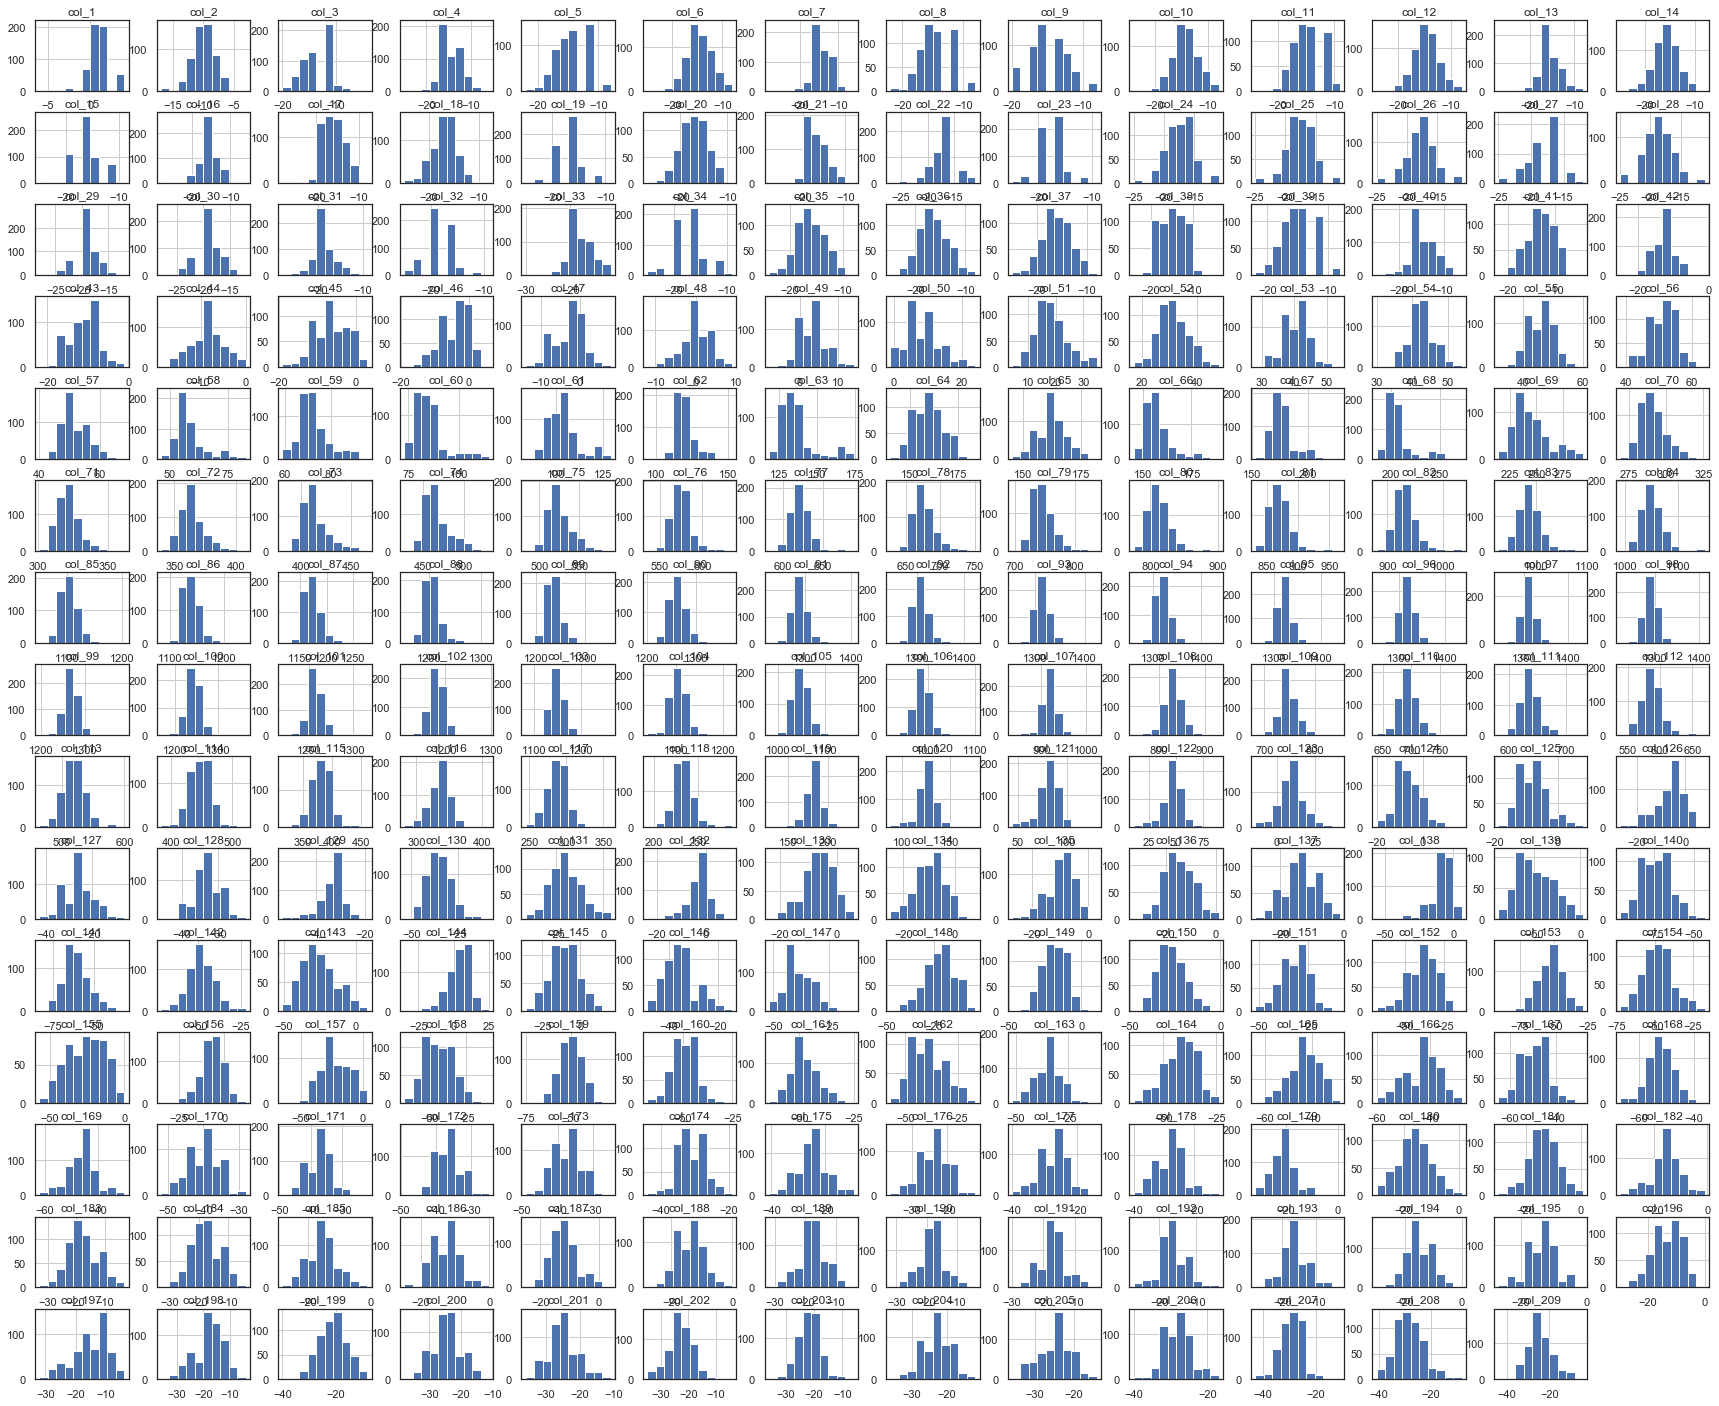

In [408]:
fig ,ax = plt.subplots(figsize=(30,25))
df.hist(ax=ax)
plt.show()
fig.savefig('hist.png')

## 2. PCA

- Using pipeline function to standardrize data, it is a important step to transform data into same scale when using techniques like PCA, because PCA is basically searching and projecting to lower dimensional linear space that contains most of  information, in other words, higher variance, so making all feature under the same scale can avoid some features being neglected due to their samll magnitude.

- Useing some visualization chart to help determine which PC numbers should be chose. Here I use variance explaination ratio, and threshold to 80%, which means almost 80% of information are preserved, the result chose 30 PCs.

In [343]:
#  PCA
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("white")

In [344]:
# make pipe
pipe=Pipeline([('scaler',StandardScaler()),
              ('pca',PCA(n_components=30))])


In [345]:
# fit th model
pc=pipe.fit_transform(df)

In [346]:
#check explained ratio
pipe.steps[1][1].explained_variance_ratio_.cumsum()

array([0.2072084 , 0.34215023, 0.42551623, 0.47729643, 0.51164904,
       0.54039985, 0.56436092, 0.58496067, 0.60160376, 0.61757353,
       0.63247944, 0.6451706 , 0.65681741, 0.66800369, 0.6789365 ,
       0.68845245, 0.69773207, 0.70684695, 0.71567016, 0.72381621,
       0.73154718, 0.73847603, 0.74517543, 0.7515403 , 0.75768561,
       0.7635613 , 0.76935479, 0.77492709, 0.78016127, 0.78530013])

In [347]:
# check how many PCs should we have
elbow_df=pd.DataFrame(pipe.steps[1][1].explained_variance_ratio_,columns=['PC_explained_ratio'])

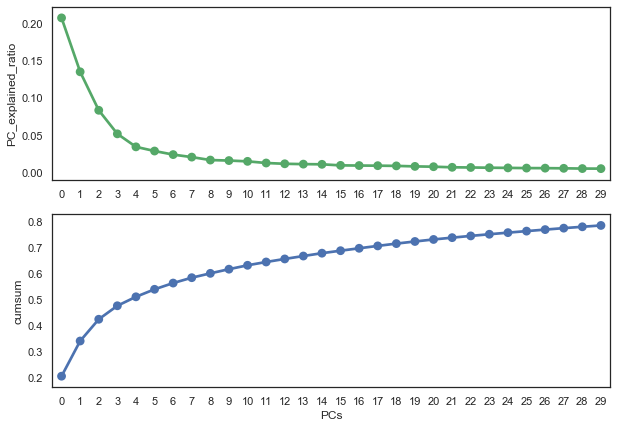

In [419]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(10,7))
sns.pointplot(x=elbow_df.index,markers='o',y='PC_explained_ratio',color='g',data=elbow_df,ax=ax1)
sns.pointplot(x=elbow_df.index,markers='o',y=elbow_df['PC_explained_ratio'].cumsum(),ax=ax2)
ax2.set_ylabel('cumsum')
ax2.set_xlabel('PCs')
plt.show()
fig.savefig('pca.png')

## 3. Visualization

- As shown below, basically data followed by Gausian distribution, most of the data locate in dense region.
    1. Pair plot
    2. t-SNE
        - A simlpe way to interpret t-SNE plot is to find clusters, but notice that the distance between each cluster has no meaning, smaller distance doesn't neccessary equal to higher similarilty. [Ref](https://distill.pub/2016/misread-tsne/)

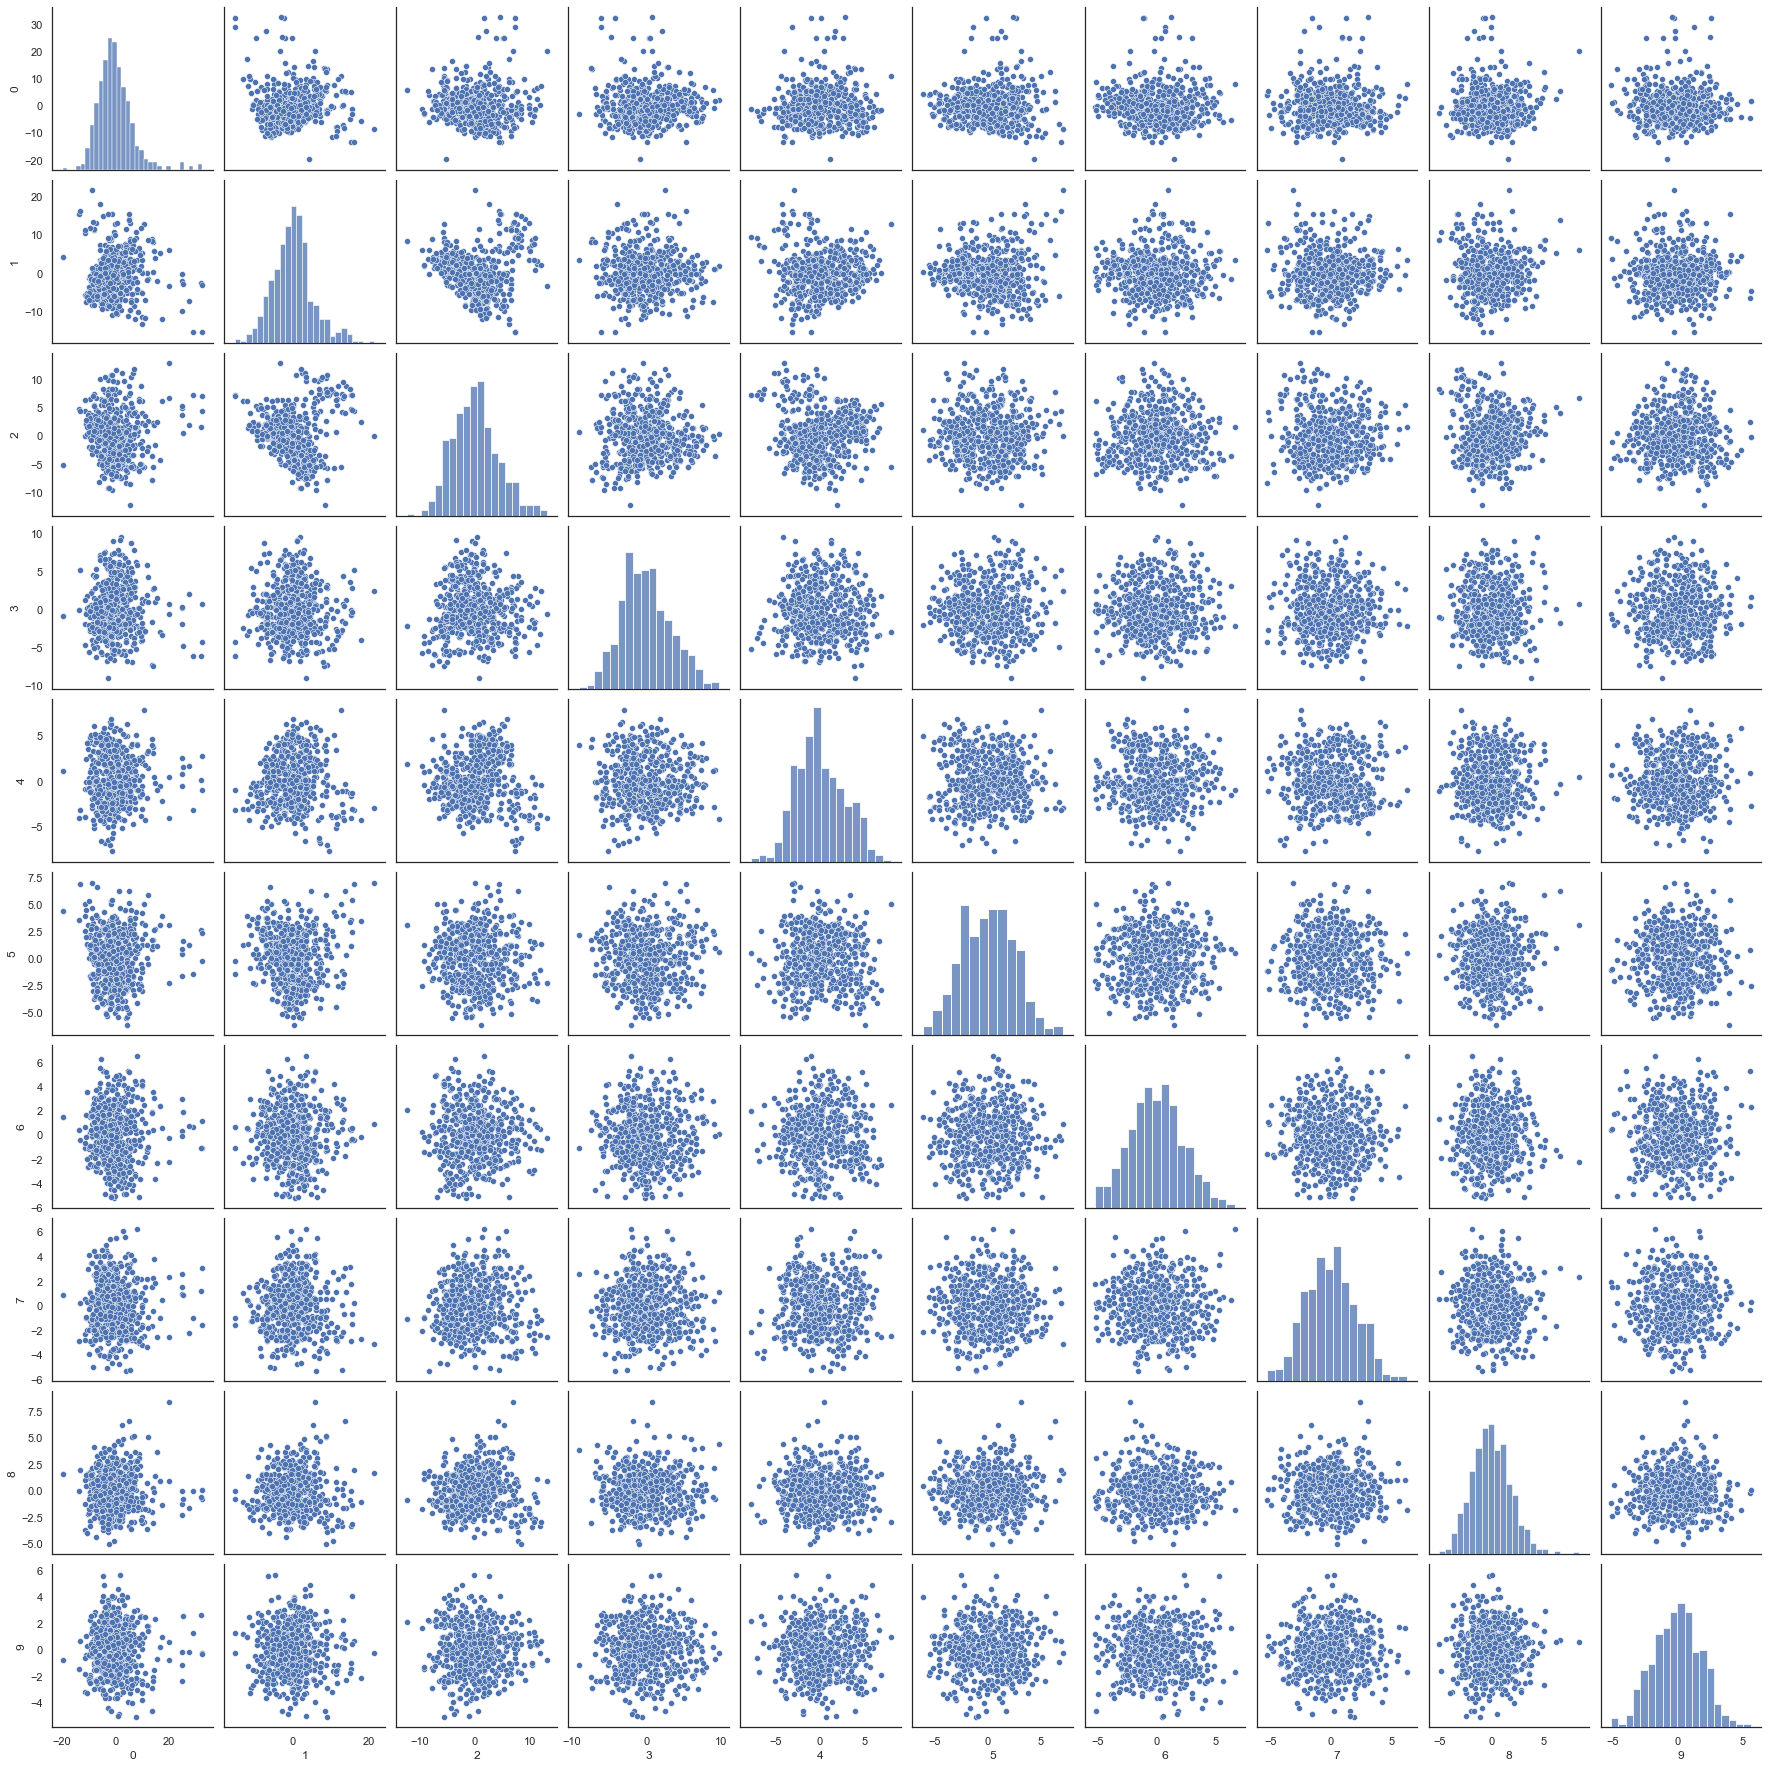

In [349]:
#pariplot of first 10 PCs
pc_plot=pd.DataFrame(pc[:,:10])
sns.pairplot(pc_plot,diag_kind='hist')
plt.show()


In [404]:
from sklearn.manifold import TSNE
# draw t-SNE
def TSNE_plot(df_plot):
    model=TSNE(learning_rate=200)
    transformed=model.fit_transform(df_plot)
    sns.scatterplot(x=transformed[:,0],y=transformed[:,1])
    plt.show()

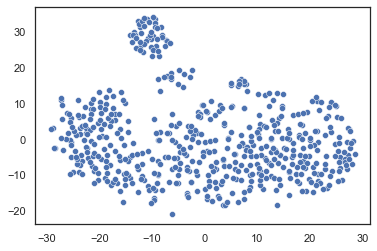

In [361]:
X = pd.DataFrame(pc)
TSNE_plot(X)

### Hyperparameter of t-SNE 

- There is a parameter called perplexity, in a sense, a guess about the number of close neighbors each point has. And has been repeatly be noted as an important setting to t-SNE. 

- At this notebook, I chose 50, since the structure from perplexity 5~50 are more similar to each other, it has higher probability to have real clusters.

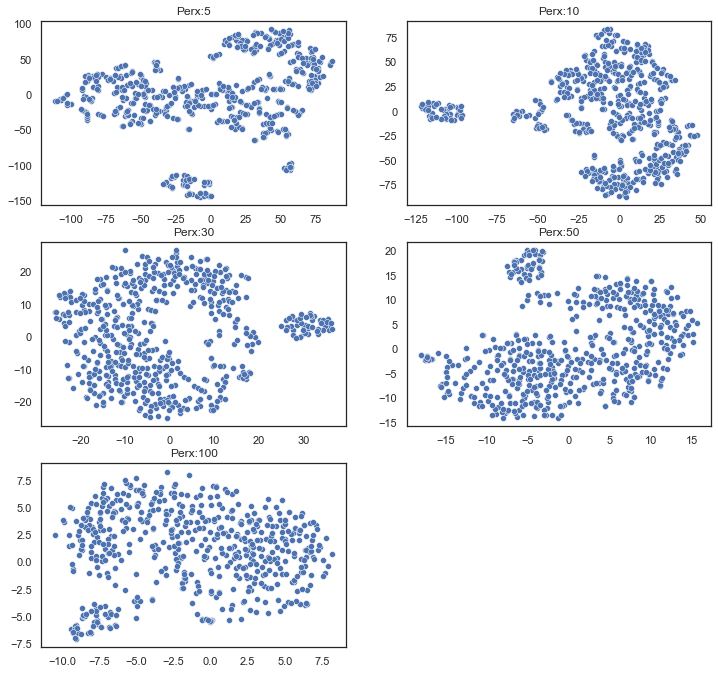

In [420]:
prex = [5,10,30,50,100]
fig = plt.figure(figsize=(12,40))
for i,rate in enumerate(prex):
    model=TSNE(perplexity=rate,n_iter=5000)
    ax = fig.add_subplot(10, 2,i+1)
    transformed=model.fit_transform(X)
    sns.scatterplot(x=transformed[:,0],y=transformed[:,1],ax=ax)
    ax.set_title("Perx:{}".format(rate))
fig.savefig("tsne.png")

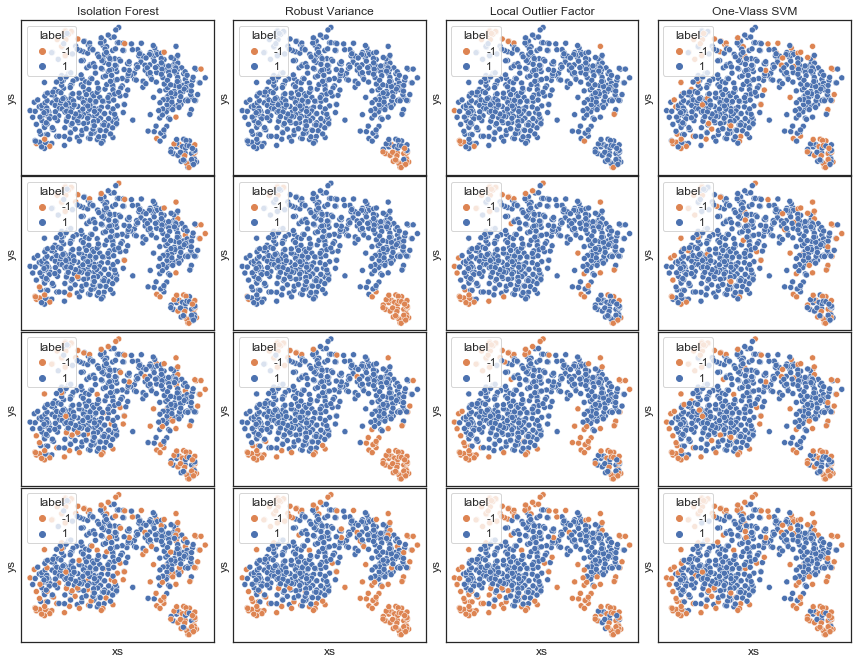

In [418]:
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm
from sklearn.manifold import TSNE

contamination = [0.05,0.1,0.2,0.3]

fig = plt.figure(figsize=(12,9))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.1,
                    hspace=.01)

# create 2d t-SNE plot
model=TSNE(perplexity=50,n_iter=5000)
transformed = model.fit_transform(X)
df_plot = pd.DataFrame(transformed, columns=['xs','ys'])

palette ={1: "C0", -1: "C1"}

plot_num = 1

for i,rate in enumerate(contamination):
    # fit_transform models
    algorithms = [("Isolation Forest",IsolationForest(contamination=rate,random_state=42)),
                  ("Robust Variance", EllipticEnvelope(contamination=rate)),
                  ("Local Outlier Factor",LocalOutlierFactor(n_neighbors=40,contamination=rate)),
                  ("One-Vlass SVM",svm.OneClassSVM(nu=rate, kernel="rbf",gamma=0.01))]
    
    for name, algor in algorithms:
        if name == "Local Outlier Factor":
            label = algor.fit_predict(X)
        else:
            label = algor.fit(X).predict(X)
        
        df_plot['label'] = label
        ax = fig.add_subplot(len(contamination),len(algorithms),plot_num)
        sns.scatterplot(x='xs',y='ys',data=df_plot,hue='label',palette=palette,ax=ax)
        if i==0:
            ax.set_title("{}".format(name))
        plt.xticks(())
        plt.yticks(())
        plot_num +=1
    
    
fig.savefig('allmodels.png')   


## 4. Isolation Forest


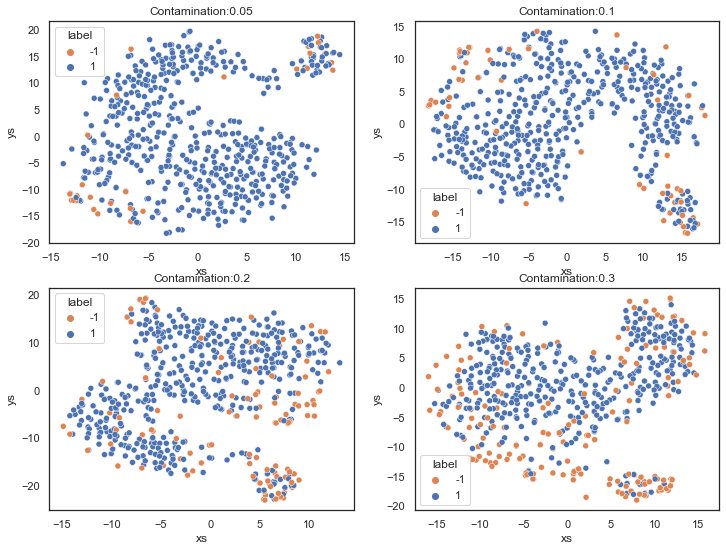

In [396]:
from sklearn.ensemble import IsolationForest

contamination = [0.05,0.1,0.2,0.3]

fig = plt.figure(figsize=(12,9))

# model = TSNE(perplexity=50learning_rate=100)

palette ={1: "C0", -1: "C1"}

for i,rate in enumerate(contamination):
    # fit_transform models
    isf = IsolationForest(contamination=rate,random_state=42)
    label = isf.fit(X).predict(X)
    
    # plot figure
    df_plot = pd.DataFrame(label,columns=['label'])
    transformed = model.fit_transform(X)
    df_plot['xs'] = transformed[:,0]
    df_plot['ys'] = transformed[:,1]
    ax = fig.add_subplot(2, 2,i+1)
    sns.scatterplot(x='xs',y='ys',data=df_plot,hue='label',palette=palette,ax=ax)
    ax.set_title("Contamination:{}".format(rate))
fig.savefig('isf.png')   

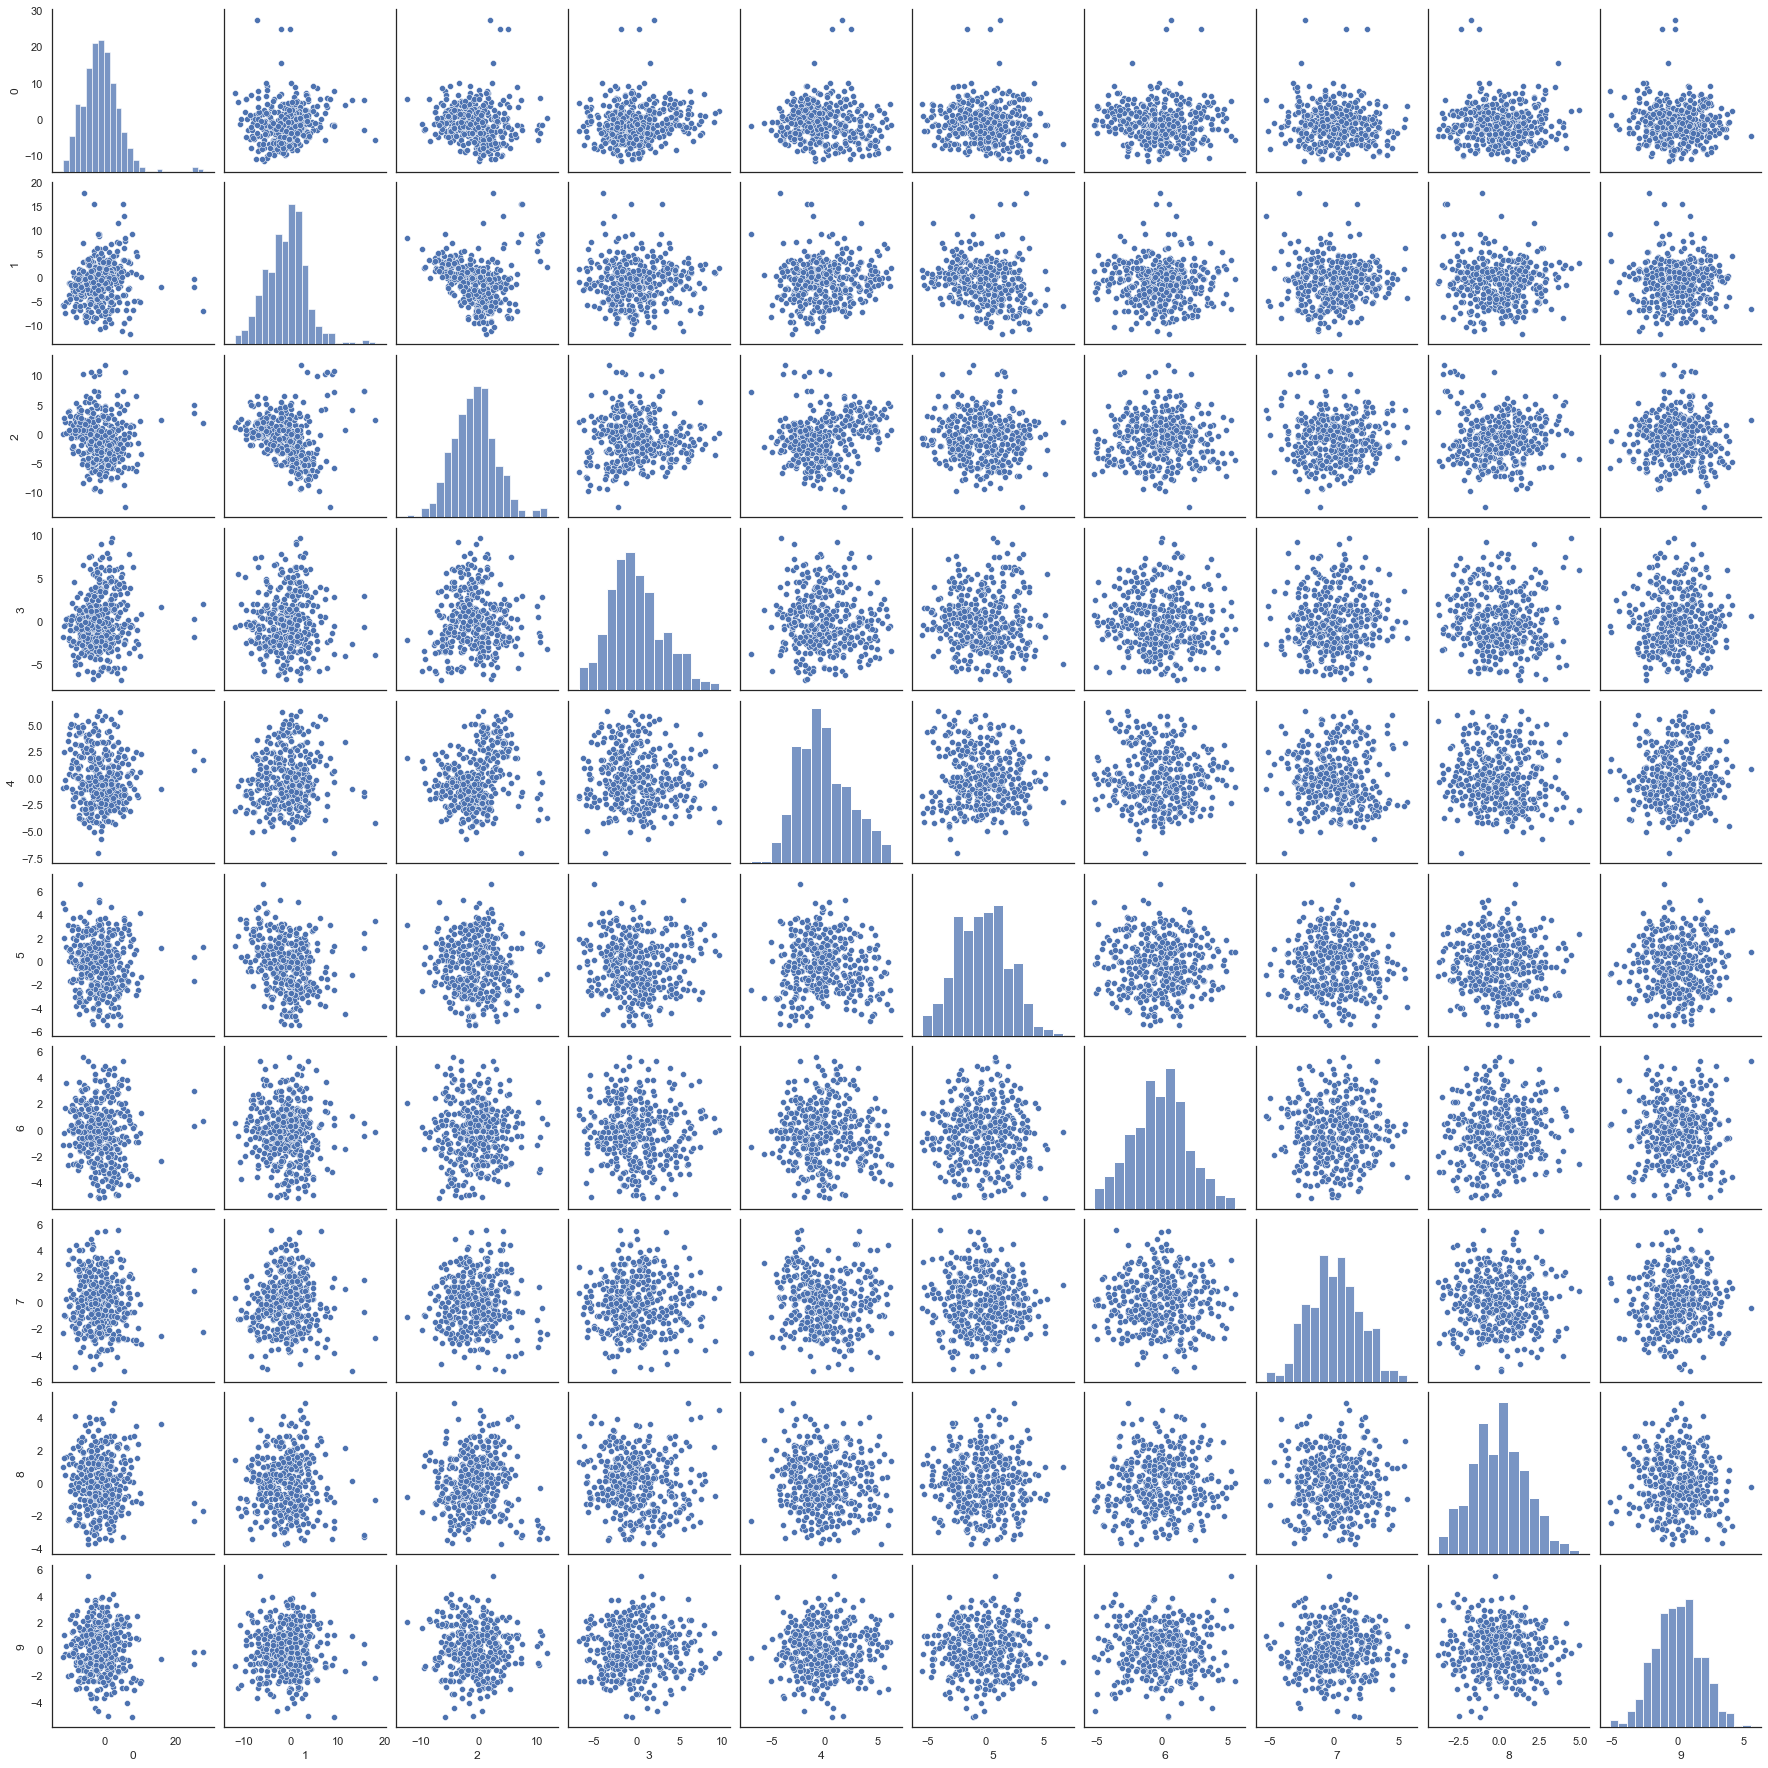

In [405]:
isf = IsolationForest(contamination=0.3,random_state=42)
label = isf.fit(X).predict(X)
X_hat = pd.DataFrame(pc)
X_hat['label'] = label
X_hat = X_hat[X_hat['label']==1]
sns.pairplot(X_hat.iloc[:,:10],diag_kind='hist')
plt.show()

## 5. Robust covariance

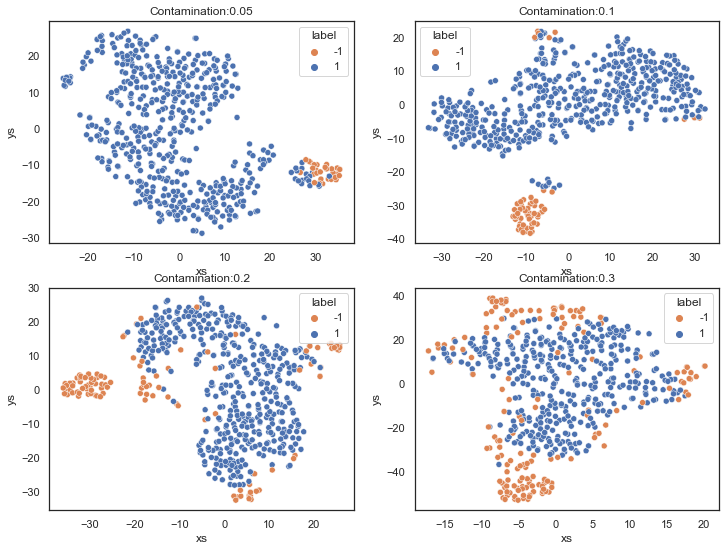

In [403]:
from sklearn.covariance import EllipticEnvelope

contamination = [0.05,0.1,0.2,0.3]

fig = plt.figure(figsize=(12,9))

#model = TSNE(learning_rate=100)

palette ={1: "C0", -1: "C1"}

for i,rate in enumerate(contamination):
    # fit_transform models
    epe = EllipticEnvelope(contamination=rate)
    label = epe.fit(X).predict(X)
    
    # plot figure
    df_plot = pd.DataFrame(label,columns=['label'])
    transformed = model.fit_transform(X)
    df_plot['xs'] = transformed[:,0]
    df_plot['ys'] = transformed[:,1]
    ax = fig.add_subplot(2, 2,i+1)
    sns.scatterplot(x='xs',y='ys',data=df_plot,hue='label',palette=palette,ax=ax)
    ax.set_title("Contamination:{}".format(rate))
fig.savefig('epe.png')

- A look on removing outliers using robust convariance methods

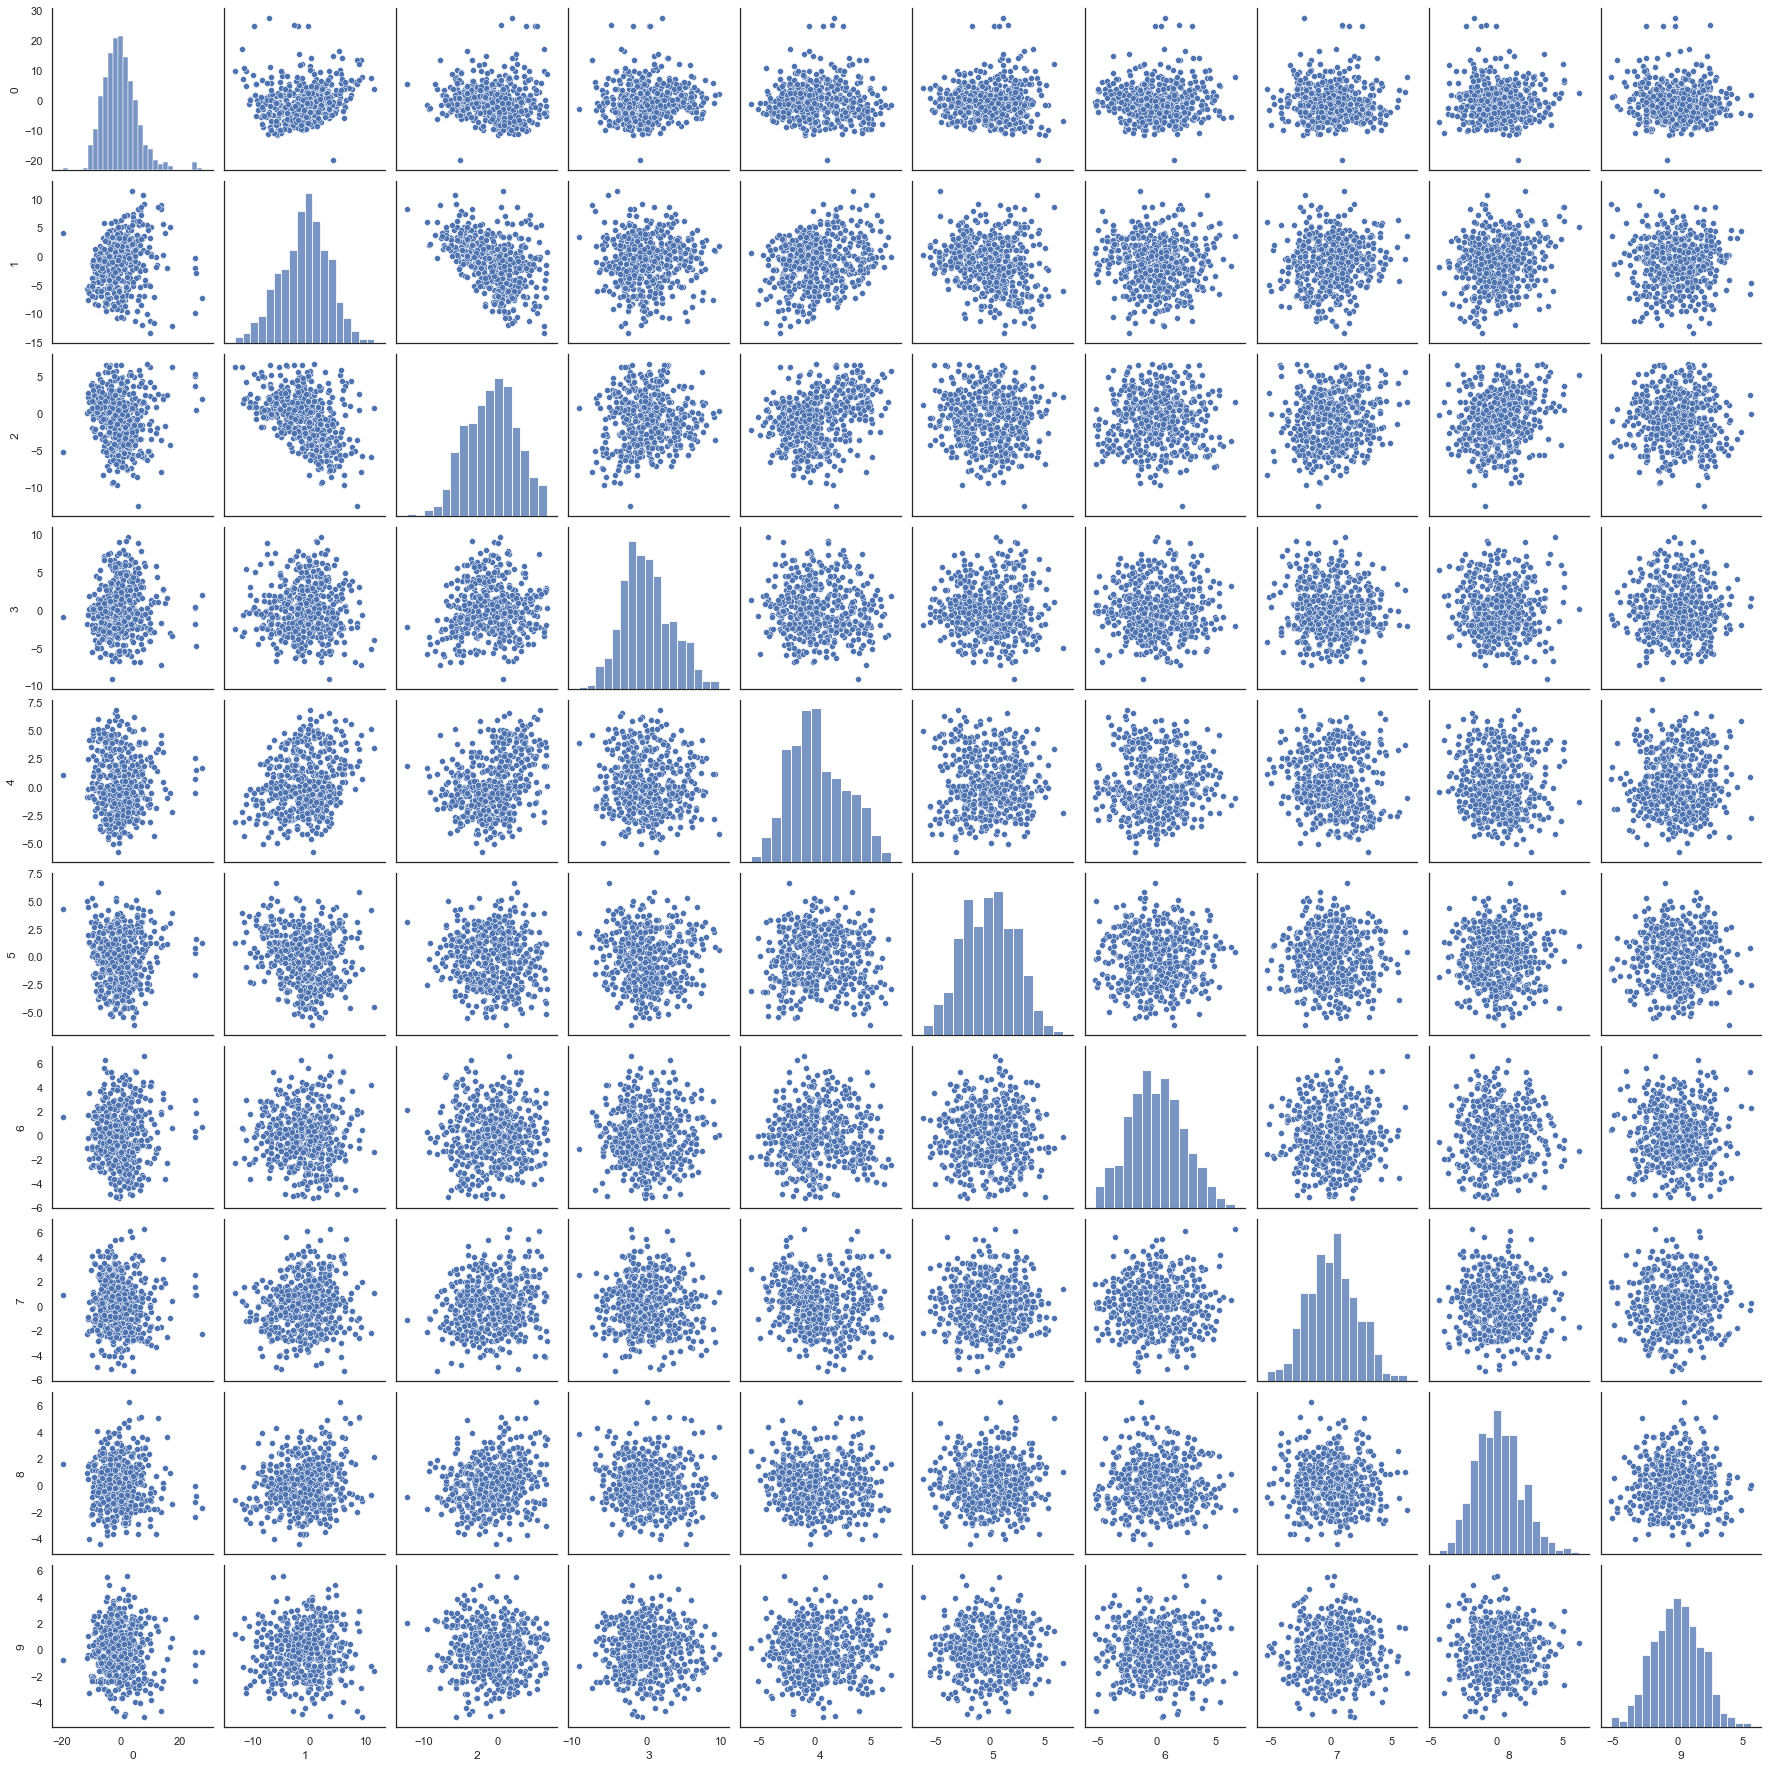

HZResults(hz=1.0003206695860491, pval=1.3850641137139162e-58, normal=False)

In [359]:
epe = EllipticEnvelope(contamination=0.1)
label = epe.fit(X).predict(X)
X_hat = pd.DataFrame(pc)
X_hat['label'] = label
X_hat = X_hat[X_hat['label']==1]
sns.pairplot(X_hat.iloc[:,:10],diag_kind='hist')
plt.show()

## 6. Local outlier

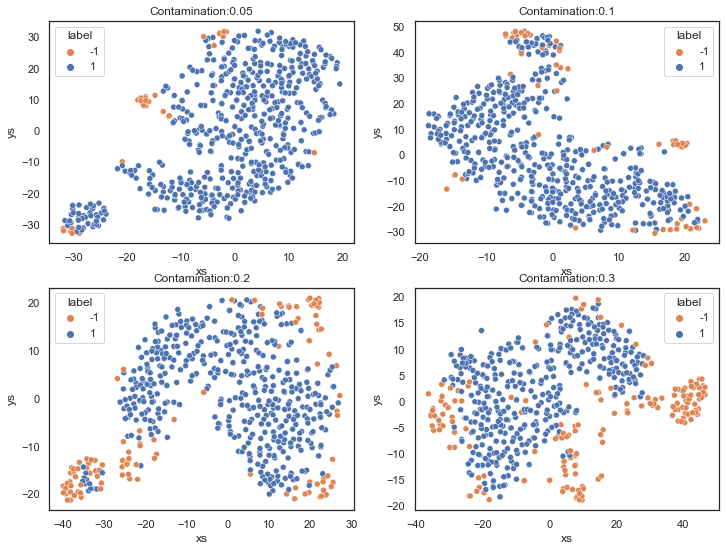

In [356]:
from sklearn.neighbors import LocalOutlierFactor

contamination = [0.05,0.1,0.2,0.3]

fig = plt.figure(figsize=(12,9))

#model = TSNE(learning_rate=100)

palette ={1: "C0", -1: "C1"}

for i,rate in enumerate(contamination):
    # fit_transform models
    lof = LocalOutlierFactor(n_neighbors=55,contamination=rate)
    label = lof.fit_predict(X)
    
    # plot figure
    df_plot = pd.DataFrame(label,columns=['label'])
    transformed = model.fit_transform(X)
    df_plot['xs'] = transformed[:,0]
    df_plot['ys'] = transformed[:,1]
    ax = fig.add_subplot(2, 2,i+1)
    sns.scatterplot(x='xs',y='ys',data=df_plot,hue='label',palette=palette,ax=ax)
    ax.set_title("Contamination:{}".format(rate))
fig.savefig('lof.png')

## 7. One-class SVM

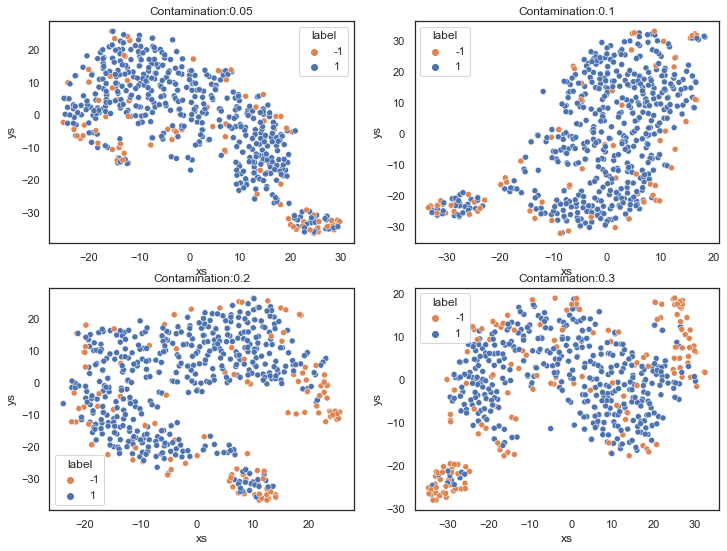

In [357]:
from sklearn import svm

contamination = [0.05,0.1,0.2,0.3]

fig = plt.figure(figsize=(12,9))

#model = TSNE(learning_rate=100)

palette ={1: "C0", -1: "C1"}

for i,rate in enumerate(contamination):
    # fit_transform models
    one_svm = svm.OneClassSVM(nu=rate, kernel="rbf",gamma=0.01)
    label = one_svm.fit(X).predict(X)
    
    # plot figure
    df_plot = pd.DataFrame(label,columns=['label'])
    transformed = model.fit_transform(X)
    df_plot['xs'] = transformed[:,0]
    df_plot['ys'] = transformed[:,1]
    ax = fig.add_subplot(2, 2,i+1)
    sns.scatterplot(x='xs',y='ys',data=df_plot,hue='label',palette=palette,ax=ax)
    ax.set_title("Contamination:{}".format(rate))
fig.savefig('svm.png')

## Conclusion 

- As t-SNE  chart shows that there seems to have two clusters, but it doesn't mean that the smaller one is outliers, also a more densed cluster doesn't mean that it has lower covariance.


- Variance : It has been observed that isolation forest local outlier factor and one-class svm tend to detect outliers starting by identifying points around the edge of clusters, so I think it is better to use these methods when detecting system errors that are generally generated because of variance, e.g. measurement error.

- Bias : On the other hand, robust variance are showing that they intend to identify points that are far from major cluster to be outliers, so I think they are better to use for detecting outliers that generated becuse of bias, means there has some shift form original pattern.





### Using unsupervise learning methods to find outliers

- Theoretically, outlier detection methods are just another kind of clustering method, but with some customization, generally, 

In [ ]:


from sklearn.cluster import KMeans

n_clusters = [2,3,4,5,6,7,8]

fig = plt.figure(figsize=(16,12))

model = TSNE(perplexity=50, n_iter=5000)

inertia = []

for i,n in enumerate(n_clusters):
    # fit_transform models
    kmean = KMeans(n_clusters=n)
    label = kmean.fit_predict(X)
    inertia.append(kmean.inertia_)
    # plot figure
    df_plot = pd.DataFrame(label,columns=['label'])
    transformed = model.fit_transform(X)
    df_plot['xs'] = transformed[:,0]
    df_plot['ys'] = transformed[:,1]
    ax = fig.add_subplot(3, 3,i+1)
    sns.scatterplot(x='xs',y='ys',data=df_plot,hue='label',ax=ax)
    ax.set_title("n_cluster:{}".format(n))
 

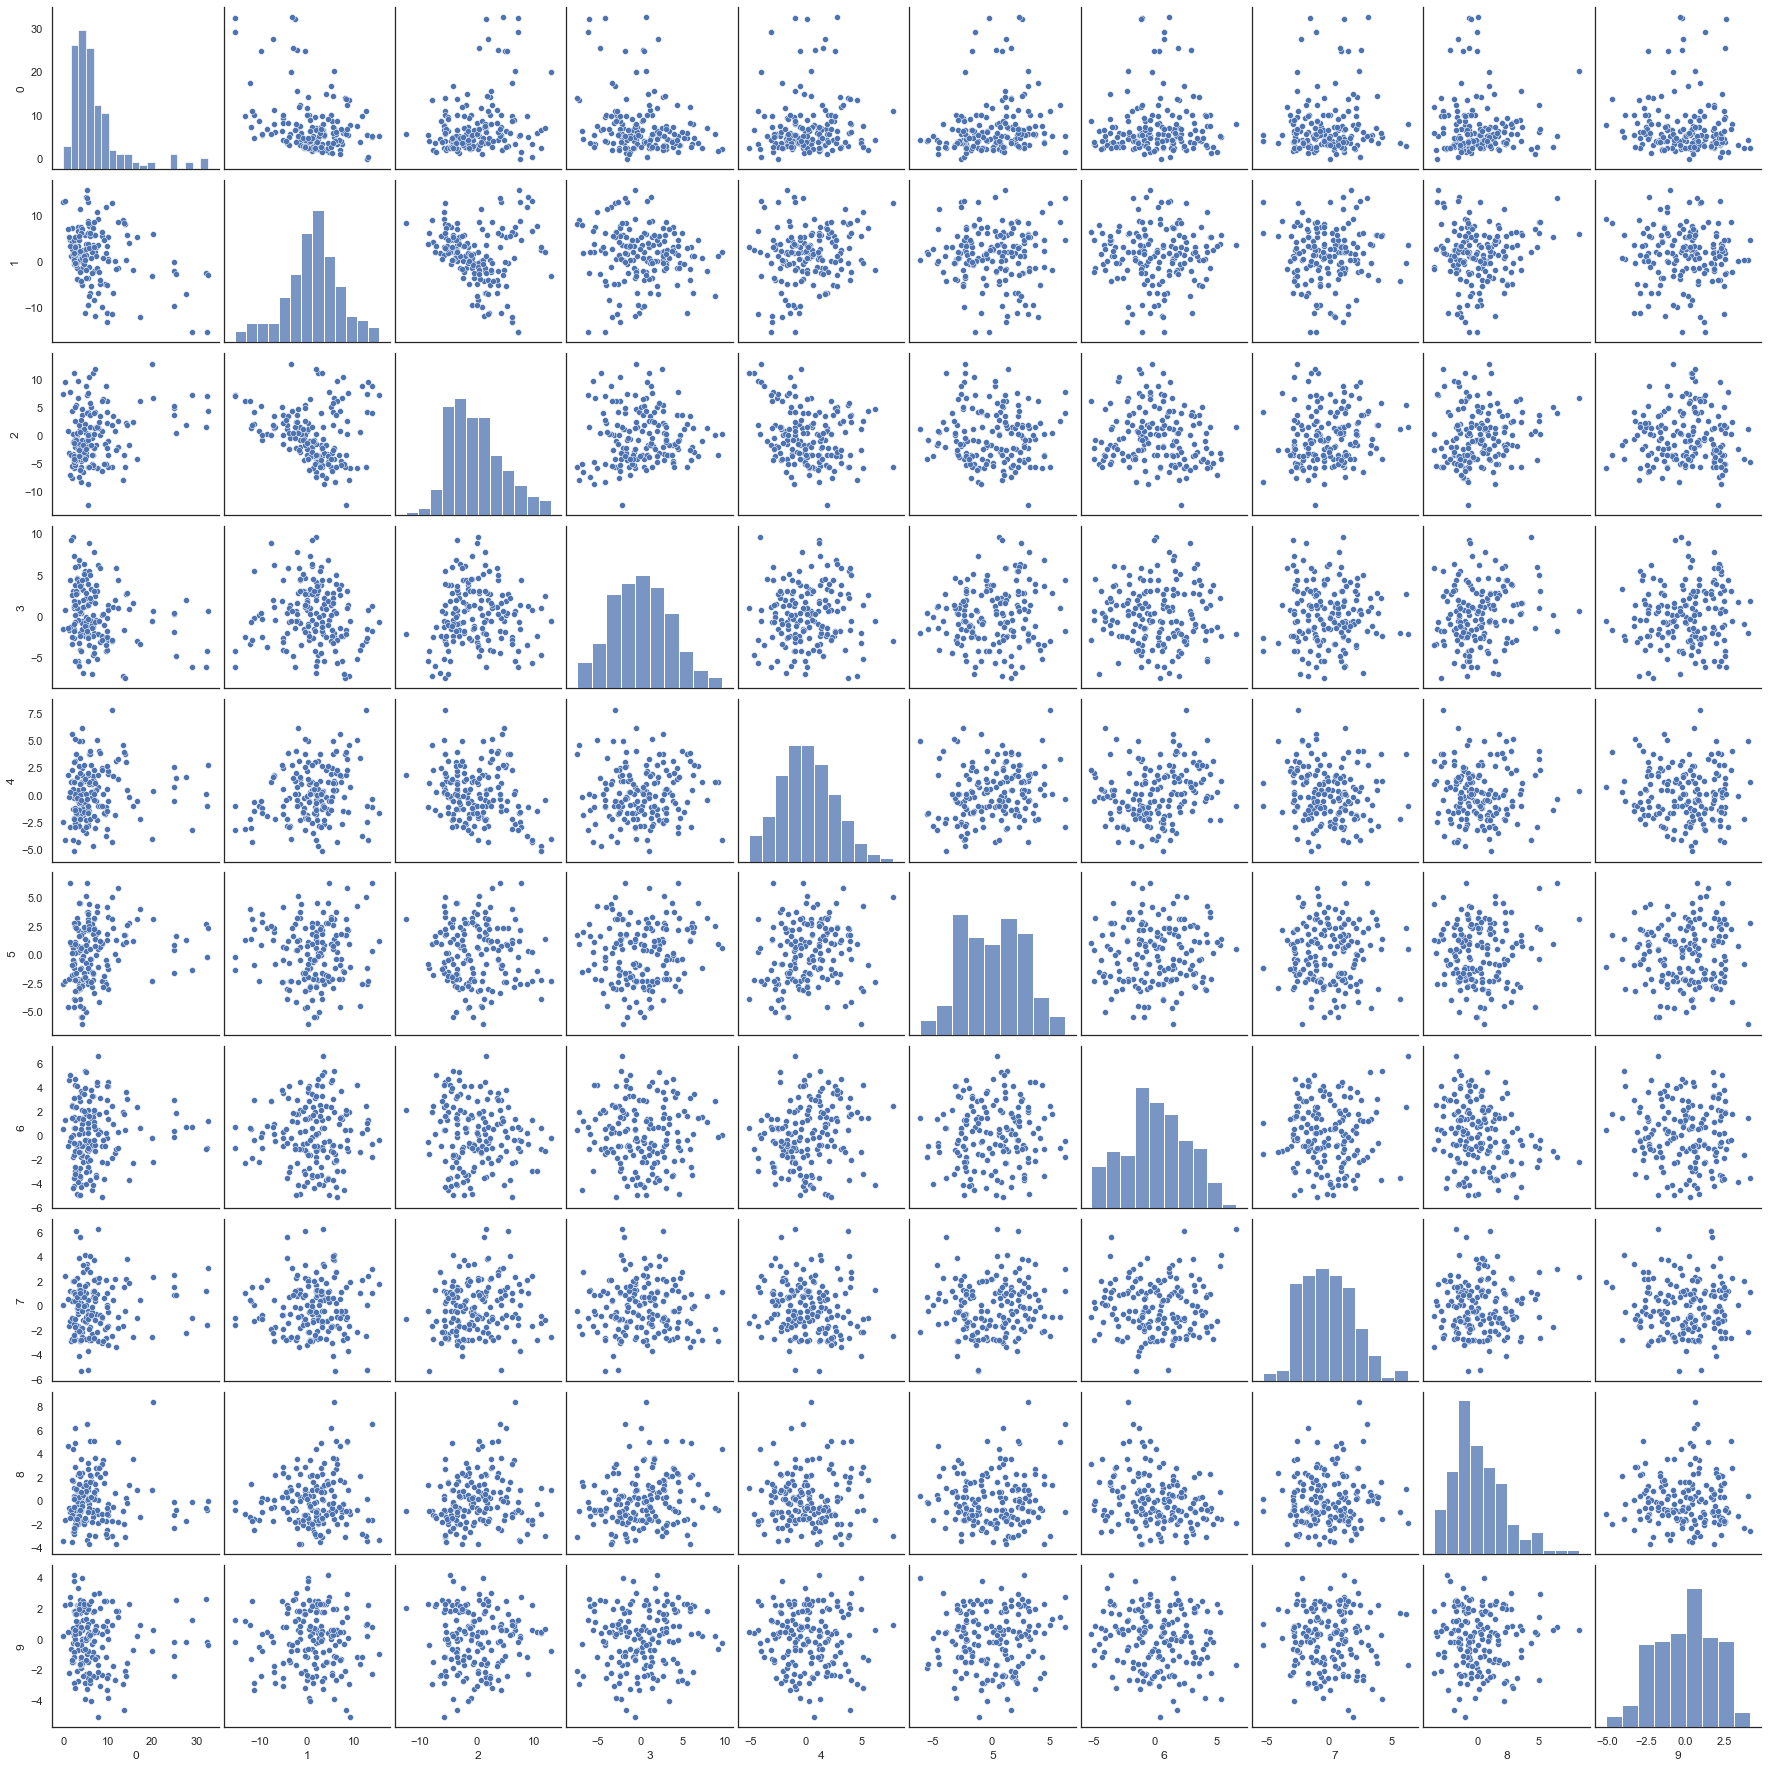

In [401]:
kmean = KMeans(n_clusters=2)
label = kmean.fit_predict(X)
X_hat = pd.DataFrame(pc)
X_hat['label'] = label
X_hat = X_hat[X_hat['label']==0]
sns.pairplot(X_hat.iloc[:,:10],diag_kind='hist')
plt.show()

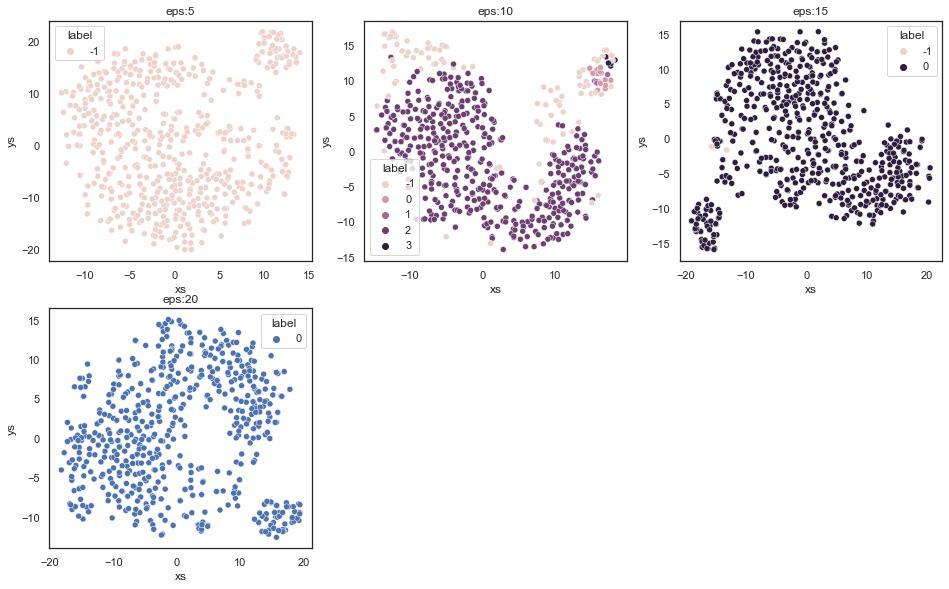

In [398]:
from sklearn.cluster import DBSCAN

eps = [5,10,15,20]

fig = plt.figure(figsize=(16,15))

model = TSNE(perplexity=50, n_iter=5000)


for i,n in enumerate(eps):
    # fit_transform models
    dbs = DBSCAN(eps=n)
    label = dbs.fit_predict(X)
    # plot figure
    df_plot = pd.DataFrame(label,columns=['label'])
    transformed = model.fit_transform(X)
    df_plot['xs'] = transformed[:,0]
    df_plot['ys'] = transformed[:,1]
    ax = fig.add_subplot(3, 3,i+1)
    sns.scatterplot(x='xs',y='ys',data=df_plot,hue='label',ax=ax)
    ax.set_title("eps:{}".format(n))

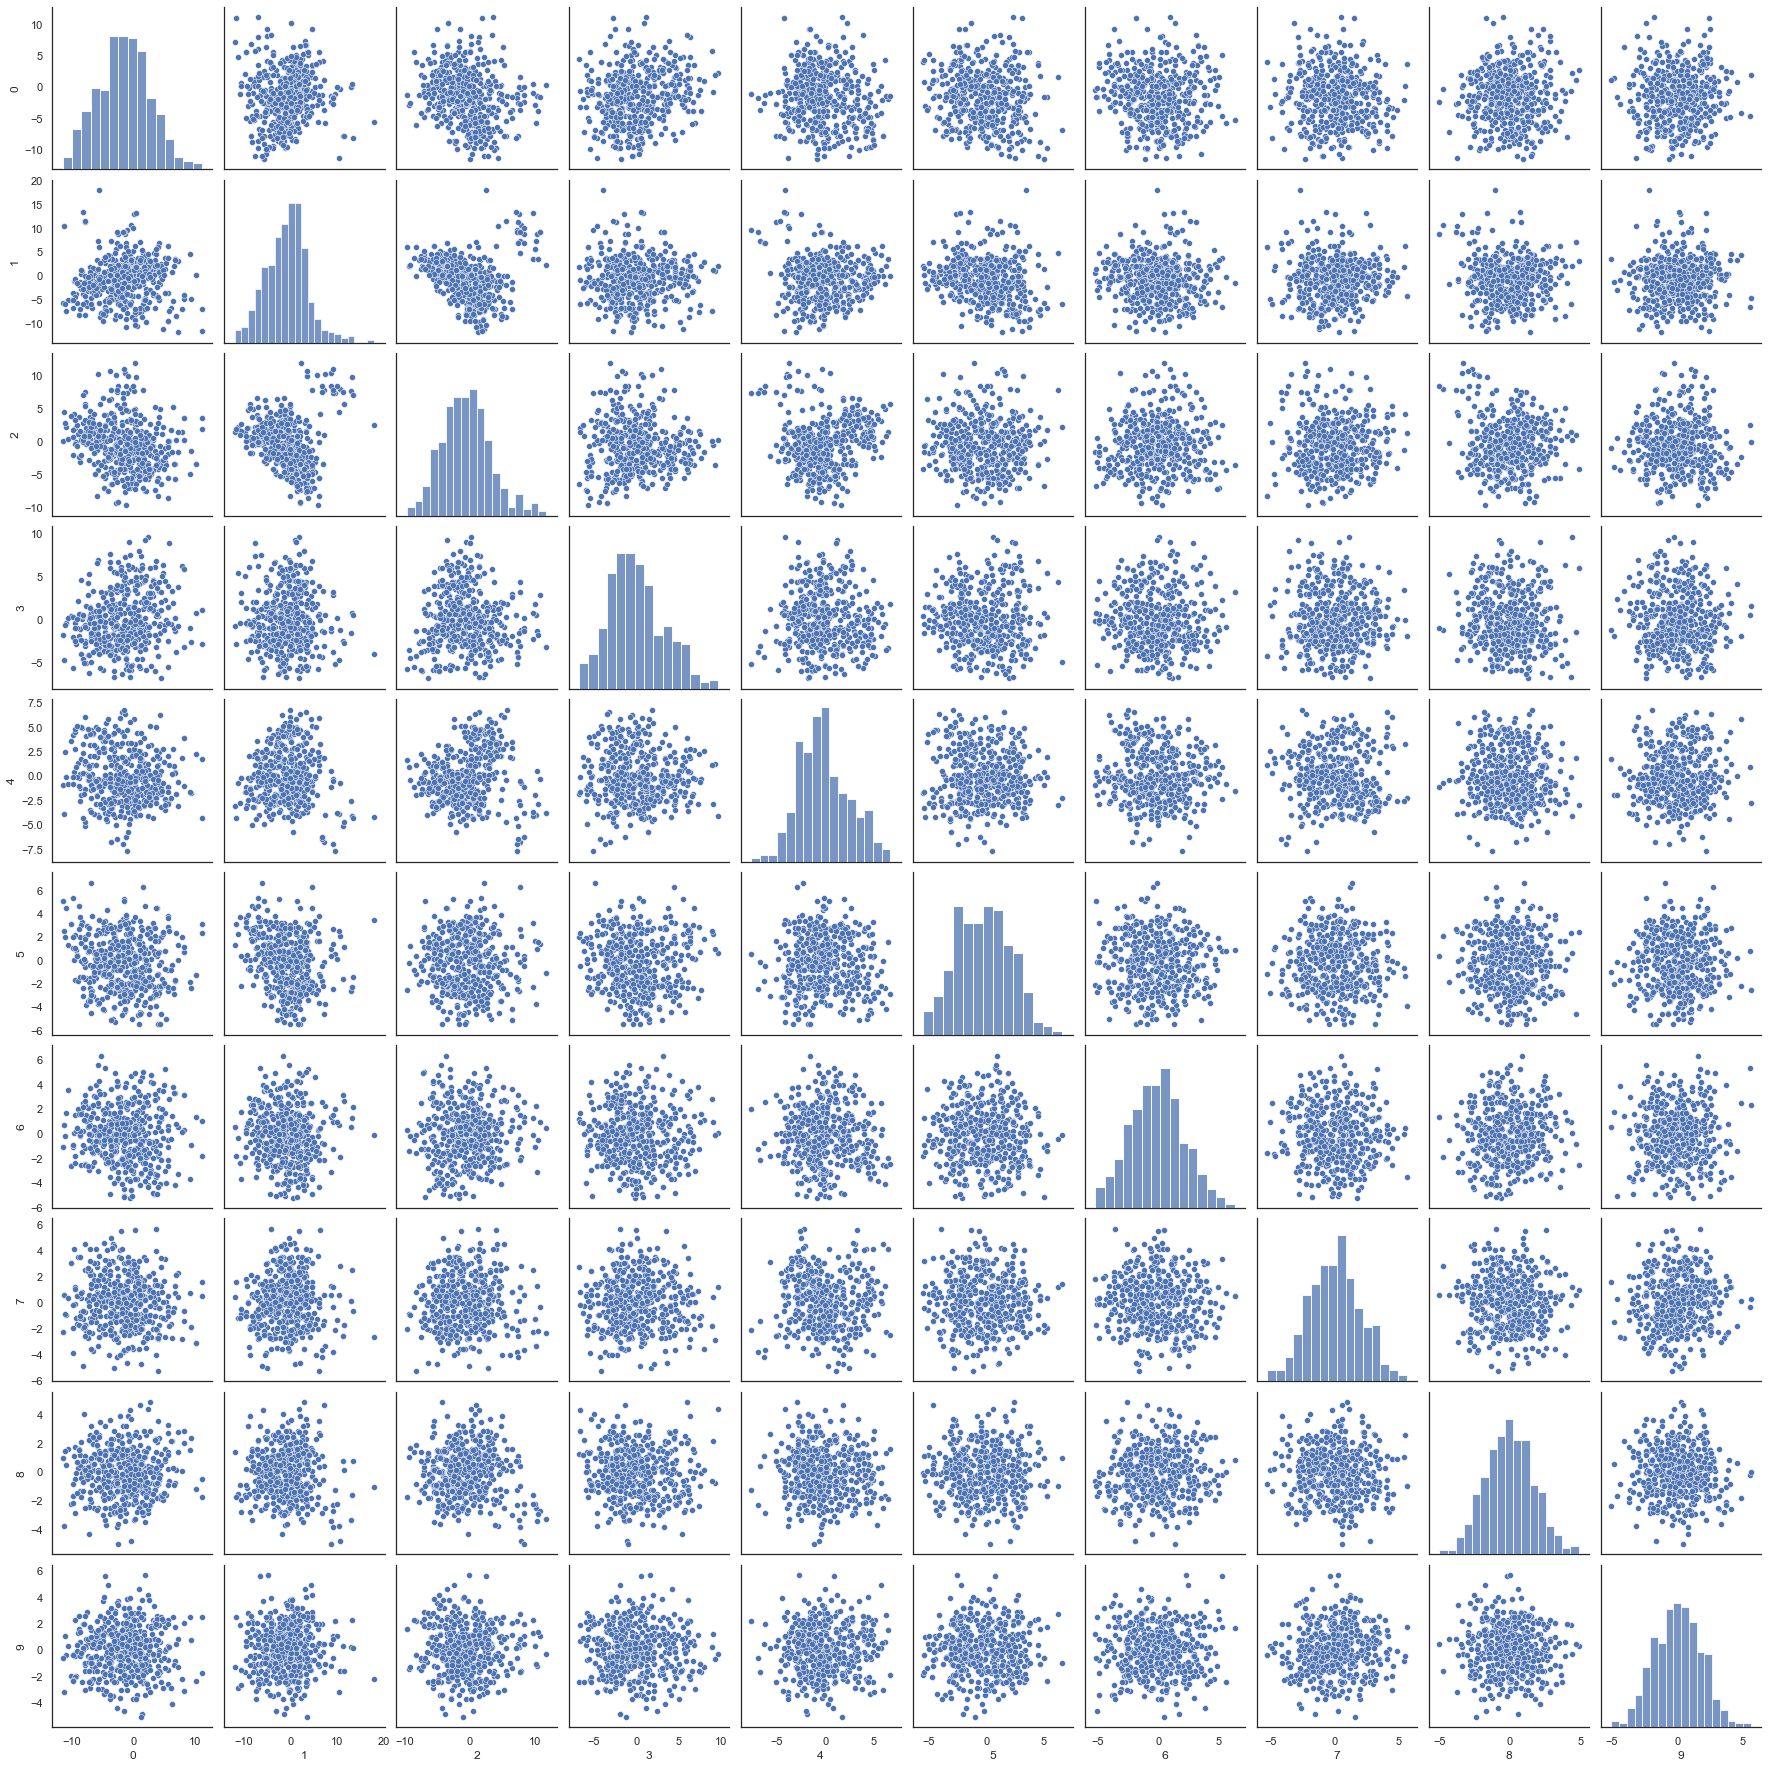

In [393]:
dbs = DBSCAN(eps=10)
label = dbs.fit_predict(X)
X_hat = pd.DataFrame(pc)
X_hat['label'] = label
X_hat = X_hat[X_hat['label']!=-1]
sns.pairplot(X_hat.iloc[:,:10],diag_kind='hist')
plt.show()
# import pingouin as pg
# pg.multivariate_normality(X_hat.drop(columns=['label']), alpha=.05)